In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import math
import io
from PIL import Image
from copy import deepcopy
from IPython.display import HTML
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")
# device='cpu'
from torch.utils.data import Dataset, DataLoader
import random
import time
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import numpy as np
from matplotlib.colors import Normalize
from torch.utils.data import DataLoader, random_split, Subset
import cv2
import math
from torchvision.transforms import Lambda



print(device)

cuda


In [20]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [23]:

path='/home/scai/mtech/aib222677/scratch/Task2/data'
data_path_Train = os.path.join(path,'train') #Enter the train folder directory
data_path_Test = os.path.join(path,'test') #Enter the test folder directory
batch_size = 30
num_workers = 2
# for normalizing (in range 0 to 1) 
class MinMaxScale:
    def __init__(self, min_val=0, max_val=1):
        self.min = min_val
        self.max = max_val
        # print(self.min, self.max)

    def __call__(self, img):
         return (img-self.min)/(self.max-self.min)

class MinMaxScaleInverse:
    def __init__(self, min_val=0, max_val=1):
        self.min = min_val
        self.max = max_val
        # print(self.min, self.max)

    def __call__(self, img):
        
         return img*(self.max-self.min)+self.min


 # min pixel value for training set:-3.1416
# max pixel value for training set:4239579

         
transform_train_x = transforms.Compose([Lambda(MinMaxScale(min_val=math.log(-3.1416+4.5), max_val=math.log(4239579+4.5)))])  # mak pixel value for training set:4239579


                             ])
transform_train_y = transforms.Compose([Lambda(MinMaxScale(min_val=math.log(-3.1416+4.5), max_val=math.log(4239579+4.5)))])

transform_test= transforms.Compose([
                                
                                Lambda(MinMaxScaleInverse(min_val=math.log(-3.1416+4.5), max_val=math.log(4239579+4.5)))
                                ])



In [24]:
# function for fourier transform
def FCT(images):
    # Convert RGB images to grayscale
    
    grayscale_images = np.mean(images, axis=-1)
    # Compute the Fourier Transform for each image
    data = np.fft.fft2(grayscale_images)


    magnitude = np.abs(data)
    phases = np.angle(data)
   

    result_array = np.stack([magnitude, phases], axis=-1)

    return result_array # result array shape:(256,256,2)

# function for inverse fourier transform ,input image of shape (2,256,256)
def inverseFCT(img):
    img=np.transpose(img,(1,2,0))
    
    magnitude=img[:,:,0]
    phase=img[:,:,1]
    # print(magnitude.shape)
    complex_image = magnitude* np.exp(1j * phase)

    # Perform the Inverse Fourier Transform
    reconstructed_image = np.fft.ifft2(complex_image)

    # Take the real part to get the original image
    original_image = np.real(reconstructed_image)

    return original_image # grayscale image

# for splitting input and target image
def split(img):
    return img[:,:,:,:256], img[:,:,:,256:]


In [25]:

# this will create a class for training data containing both mri sequences (real and target) as a single merge image of shape (256,512)
class MRIImage(Dataset):
    def __init__(self, data_dir, transform1=None,transform2=None):
        self.data_dir = data_dir
        self.transform1 = transform1
        self.transform2=transform2
        self.image_paths = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir)] # path for training data

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        image =np.asarray(image)
        
        
        
       
        img1=image[:,:256,:] # splitting x and y 
        img2=image[:,256:,:]

        img1=FCT(img1) # taking fourier of both x and y 
        img2=FCT(img2)


        img1=np.transpose(img1,(2,0,1))
        img2=np.transpose(img2,(2,0,1))

         
        
        img1=torch.from_numpy(img1).float()
        img2=torch.from_numpy(img2).float()
        
# taking log to lessen the difference between pixel values so that after normalizing results does not become of too small values and adding 4.5 to make min value of pixel as greater than 0
        img1=torch.log(img1+4.5) 
        img2=torch.log(img2+4.5)
        
        if self.transform1:
            img1= self.transform1(img1)
            
        if self.transform2:
            img2=self.transform2(img2)
            
        image=torch.cat((img1, img2), dim=2)
        
        
        return image

In [26]:

# this will create a class for test data containing both mri sequences (real and target) as a single merge image of shape (256,512)
class MRIImageTest(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        self.image_paths = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        
        if self.transform:
            image = self.transform(image)

        return image




In [27]:

# Load the entire training dataset
full_dataset =MRIImage(data_dir=data_path_Train, transform1=transform_train_x,transform2=transform_train_y)

train_dataset=full_dataset
# print(len(train_dataset))
# Create a data loader for training
load_Train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)


torch.Size([2, 256, 512])
52390


In [28]:
# Load the entire test dataset
full_test_dataset = MRIImage(data_dir=data_path_Test, transform1=transform_train_x,transform2=transform_train_y)

test_dataset=full_test_dataset
# print(len(test_dataset))
# Create a data loader for testing
load_Test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


3100


In [30]:
inst_norm = True if batch_size==1 else False  # instance normalization


def conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    return nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride,
    padding=padding)


def conv_n(in_channels, out_channels, kernel_size, stride=1, padding=0, inst_norm=False):
    if inst_norm == True:
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size,
        stride=stride, padding=padding), nn.InstanceNorm2d(out_channels,
        momentum=0.1, eps=1e-5),)
    else:
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size,
        stride=stride, padding=padding), nn.BatchNorm2d(out_channels,
        momentum=0.1, eps=1e-5),)

def tconv(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0,):
    return nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride,
    padding=padding, output_padding=output_padding)

def tconv_n(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, inst_norm=False):
    if inst_norm == True:
        return nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
        stride=stride, padding=padding, output_padding=output_padding),
        nn.InstanceNorm2d(out_channels, momentum=0.1, eps=1e-5),)
    else:
        return nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
        stride=stride, padding=padding, output_padding=output_padding),
        nn.BatchNorm2d(out_channels, momentum=0.1, eps=1e-5),)

In [31]:
dim_c = 2
dim_g = 64

# Generator class designed for taking input of shape (256,256,2)
class Gen(nn.Module):
    def __init__(self, inst_norm=False):
        super(Gen,self).__init__()
        self.n1 = conv(dim_c, dim_g, 4, 2, 1)
        self.n2 = conv_n(dim_g, dim_g*2, 4, 2, 1, inst_norm=inst_norm)
        self.n3 = conv_n(dim_g*2, dim_g*4, 4, 2, 1, inst_norm=inst_norm)
        self.n4 = conv_n(dim_g*4, dim_g*8, 4, 2, 1, inst_norm=inst_norm)
        self.n5 = conv_n(dim_g*8, dim_g*8, 4, 2, 1, inst_norm=inst_norm)
        self.n6 = conv_n(dim_g*8, dim_g*8, 4, 2, 1, inst_norm=inst_norm)
        self.n7 = conv_n(dim_g*8, dim_g*8, 4, 2, 1, inst_norm=inst_norm)
        self.n8 = conv(dim_g*8, dim_g*8, 4, 2, 1)

        self.m1 = tconv_n(dim_g*8, dim_g*8, 4, 2, 1, inst_norm=inst_norm)
        self.m2 = tconv_n(dim_g*8*2, dim_g*8, 4, 2, 1, inst_norm=inst_norm)
        self.m3 = tconv_n(dim_g*8*2, dim_g*8, 4, 2, 1, inst_norm=inst_norm)
        self.m4 = tconv_n(dim_g*8*2, dim_g*8, 4, 2, 1, inst_norm=inst_norm)
        self.m5 = tconv_n(dim_g*8*2, dim_g*4, 4, 2, 1, inst_norm=inst_norm)
        self.m6 = tconv_n(dim_g*4*2, dim_g*2, 4, 2, 1, inst_norm=inst_norm)
        self.m7 = tconv_n(dim_g*2*2, dim_g*1, 4, 2, 1, inst_norm=inst_norm)
        self.m8 = tconv(dim_g*1*2, dim_c, 4, 2, 1)
        self.tanh = nn.Tanh()

    def forward(self,x):
        n1 = self.n1(x)
        n2 = self.n2(F.leaky_relu(n1, 0.2))
        n3 = self.n3(F.leaky_relu(n2, 0.2))
        n4 = self.n4(F.leaky_relu(n3, 0.2))
        n5 = self.n5(F.leaky_relu(n4, 0.2))
        n6 = self.n6(F.leaky_relu(n5, 0.2))
        n7 = self.n7(F.leaky_relu(n6, 0.2))
        n8 = self.n8(F.leaky_relu(n7, 0.2))
        m1 = torch.cat([F.dropout(self.m1(F.relu(n8)), 0.5, training=True), n7], 1)
        m2 = torch.cat([F.dropout(self.m2(F.relu(m1)), 0.5, training=True), n6], 1)
        m3 = torch.cat([F.dropout(self.m3(F.relu(m2)), 0.5, training=True), n5], 1)
        m4 = torch.cat([self.m4(F.relu(m3)), n4], 1)
        m5 = torch.cat([self.m5(F.relu(m4)), n3], 1)
        m6 = torch.cat([self.m6(F.relu(m5)), n2], 1)
        m7 = torch.cat([self.m7(F.relu(m6)), n1], 1)
        m8 = self.m8(F.relu(m7))

        return self.tanh(m8)

In [32]:
dim_d = 64
# Discriminator class designed for taking input of shape (256,256,2)
class Disc(nn.Module):
    def __init__(self, inst_norm=False):
        super(Disc,self).__init__()
        self.c1 = conv(dim_c*2, dim_d, 4, 2, 1)
        self.c2 = conv_n(dim_d, dim_d*2, 4, 2, 1, inst_norm=inst_norm)
        self.c3 = conv_n(dim_d*2, dim_d*4, 4, 2, 1, inst_norm=inst_norm)
        self.c4 = conv_n(dim_d*4, dim_d*8, 4, 1, 1, inst_norm=inst_norm)
        self.c5 = conv(dim_d*8, 1, 4, 1, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, y):
        xy=torch.cat([x,y],dim=1)
        xy=F.leaky_relu(self.c1(xy), 0.2)
        xy=F.leaky_relu(self.c2(xy), 0.2)
        xy=F.leaky_relu(self.c3(xy), 0.2)
        xy=F.leaky_relu(self.c4(xy), 0.2)
        xy=self.c5(xy)

        return self.sigmoid(xy)

def weights_init(z):
    cls_name =z.__class__.__name__
    if cls_name.find('Conv')!=-1 or cls_name.find('Linear')!=-1:
        nn.init.normal_(z.weight.data, 0.0, 0.02)
        nn.init.constant_(z.bias.data, 0)
    elif cls_name.find('BatchNorm')!=-1:
        nn.init.normal_(z.weight.data, 1.0, 0.02)
        nn.init.constant_(z.bias.data, 0)

In [33]:
BCE = nn.BCELoss() #binary cross-entropy
L1 = nn.L1Loss() #L1 loss
L2=nn.MSELoss()  #L2 loss
#instance normalization
Gen_model = Gen(inst_norm).to(device)
Disc = Disc(inst_norm).to(device)
generator = Gen(inst_norm).to(device)
#optimizers
# Gen_optim = optim.Adam(Gen.parameters(), lr=2e-4, betas=(0.5, 0.999), weight_decay=0.35)
Gen_optim = optim.Adam(Gen_model.parameters(), lr=2e-1, betas=(0.5, 0.999))   #lr=2e-3
Disc_optim = optim.Adam(Disc.parameters(), lr=2e-6, betas=(0.5, 0.999))   # lr=2e-6

In [35]:

# training and displaying the results of training on few training samples

min_value=math.log(-3.1416+4.5)
max_value=math.log(4239579+4.5)


iter_per_plot = 10
epochs = 5
L1_lambda = 1.0


for ep in range(epochs):
    for i, data in enumerate(load_Train):
        size = data.shape[0]

        x, y = split(data.to(device))
        

        r_masks = torch.ones(size,1,30,30).to(device)
        f_masks = torch.zeros(size,1,30,30).to(device)

        fake=Gen_model(x)

        # if want to calculate in spatial domain

        # yfake_tensor = torch.zeros(fake.shape[0], 2, 256, 256)
        # for j in range(fake.shape[0]):
        #     fakeRGB=fake[j].cpu().detach().numpy()
        #     fakeRGB=fakeRGB*(max_value-min_value)+min_value
        #     fakeRGB=np.exp(fakeRGB)-4
        #     fakeRGB=inverseFCT(fakeRGB)
        #     fakeRGB=np.expand_dims(fakeRGB, axis=-1)
        #     fakeRGB=np.transpose(fakeRGB,(2,0,1))
        #     fake_torch=torch.from_numpy(fakeRGB).float()
        #     fake_torch = torch.cat([fake_torch, fake_torch], dim=0)
            
        #     yfake_tensor[j]=fake_torch
            
        # yfake_tensor=yfake_tensor.to(device)


        # y_tensor = torch.zeros(y.shape[0], 2, 256, 256)
        # for j in range(y.shape[0]):
        #     fakeRGB=y[j].cpu().detach().numpy()
        #     fakeRGB=fakeRGB*(max_value-min_value)+min_value
        #     fakeRGB=np.exp(fakeRGB)-4
        #     fakeRGB=inverseFCT(fakeRGB)
        #     fakeRGB=np.expand_dims(fakeRGB, axis=-1)
        #     fakeRGB=np.transpose(fakeRGB,(2,0,1))
        #     fake_torch=torch.from_numpy(fakeRGB).float()
        #     fake_torch = torch.cat([fake_torch, fake_torch], dim=0)
            
        #     y_tensor[j]=fake_torch
            
        # y_tensor=y_tensor.to(device)

        # x_tensor = torch.zeros(x.shape[0], 2, 256, 256)
        # for j in range(x.shape[0]):
        #     fakeRGB=x[j].cpu().detach().numpy()
        #     fakeRGB=fakeRGB*(max_value-min_value)+min_value
        #     fakeRGB=np.exp(fakeRGB)-4
        #     fakeRGB=inverseFCT(fakeRGB)
        #     fakeRGB=np.expand_dims(fakeRGB, axis=-1)
        #     fakeRGB=np.transpose(fakeRGB,(2,0,1))
        #     fake_torch=torch.from_numpy(fakeRGB).float()
        #     fake_torch = torch.cat([fake_torch, fake_torch], dim=0)
            
        #     x_tensor[j]=fake_torch
            
        # x_tensor=x_tensor.to(device)
    
        Disc.zero_grad()
        r_patch=Disc(y,x)  # y_tensor and x_tensor if  want calculated in spatail domain

        
        r_disc_loss=L2(r_patch,r_masks)
       
        

        
        #fake_patch
        f_patch = Disc(fake,x)   #yfake_tensor and x_tensor if  want calculated in spatail domain
        f_disc_loss=L2(f_patch,f_masks)
        Disc_loss = r_disc_loss + f_disc_loss
       
        Disc_loss.backward()
        Disc_optim.step()

        # gen
        
        Gen_model.zero_grad()
        f_patch = Disc(fake,x) #yfake_tensor and x_tensor if  want calculated in spatail domain
        f_gan_loss=L2(f_patch,r_masks)

        L1_loss = L1(fake,y)  #yfake_tensor and y_tensor if  want calculated in spatail domain
        Gen_loss = f_gan_loss + L1_lambda*L1_loss
        
        Gen_loss.backward()

        Gen_optim.step()
        
        
        if (i+1)%iter_per_plot == 0 :
            print('Epoch [{}/{}], Step [{}/{}], disc_loss: {:.4f}, gen_loss: {:.4f},Disc(real): {:.2f}, Disc(fake):{:.2f}, gen_loss_gan:{:.4f}, gen_loss_L1:{:.4f}'.format(ep+1, epochs, i+1, len(load_Train), Disc_loss.item(), Gen_loss.item(), r_disc_loss.item(), f_disc_loss.item(), f_gan_loss.item(), L1_loss.item()))
            
    if (ep+1)==epochs:
    
        with torch.no_grad():
            Gen_model.eval()
            for data in load_Train:
                # print(data.shape)
                x, y = split(data.to(device))
                fake = Gen_model(x)
                for j in range(fake.shape[0]):
                    if j%10==0:
                        t_y=y[j].cpu().detach().numpy()
                        fk_batch=fake[j].cpu().detach().numpy()
                        t_x=x[j].cpu().detach().numpy()
                        
                        t_x=t_x*(max_value-min_value)+min_value
                        t_y=t_y*(255)
                        fk_batch=fk_batch*(max_value-min_value)+min_value
                        
                        t_x=np.exp(t_x)-4
                        # t_y=np.exp(t_y)-4
                        t_y=t_y[0,:,:]
                        fk_batch=np.exp(fk_batch)-4
                        
                        t_x=inverseFCT(t_x)
                        # t_y=inverseFCT(t_y)
                        fk_batch=inverseFCT(fk_batch)
                        
                        plt.figure(figsize=(10, 4))
                        
                        # Plotting the first array
                        plt.subplot(1, 3, 1)
                        plt.imshow(t_x)
                        plt.title('input')
                        
                        # Plotting the second array
                        plt.subplot(1, 3, 2)
                        plt.imshow(fk_batch)
                        plt.title('generated image')
                        
                        # Plotting the third array
                        plt.subplot(1, 3, 3)
                        plt.imshow(t_y)
                        plt.title('ground truth')

                break
            Gen_model.train()
            
    if ep+1==epochs:
        torch.save(Gen_model.state_dict(), 't1_to_t2_model_fourier_newlearning.pth')  # saving the model after training
            


In [36]:
# calculating rmse on test dataset
error_list=[]

generator.load_state_dict(torch.load('t1_to_t2_model_fourier.pth', map_location=device))  # load the saved model

batch_size = 1  # Set the batch size to 1 to get a single image in each iteration
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for data in tqdm(test_loader):
    t_batch=data
    t_x, t_y = split(t_batch)
    
    with torch.no_grad():
        generator.eval()
        fk_batch=generator(t_x.to(device))
    t_y=t_y.numpy()
    fk_batch=fk_batch.cpu().detach().numpy()
    t_y=t_y*(max_value-min_value)+min_value
    fk_batch=fk_batch*(max_value-min_value)+min_value

    t_y=np.exp(t_y.squeeze())-4.5
    fk_batch=np.exp(fk_batch.squeeze())-4.5

   
    
    
    t_y=inverseFCT(t_y)
    fk_batch=inverseFCT(fk_batch)
    
    error_list.append(np.sqrt(np.sum((t_y-fk_batch)**2)))
    

error_list=np.array(error_list)


print('mean rmse error :',np.mean(error_list))
print('max rmse error:',np.max(error_list))
print('min rmse error:',np.min(error_list))



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3100/3100 [02:39<00:00, 19.42it/s]

mean rmse error : 25253.343879202315
max rmse error: 115793.7156571718
min rmse error: 265.9584970464973


In [79]:

# function to calculate normalized log magnitude
def fft_visual(img):
    
    img=np.transpose(img,(1,2,0))
    
    magnitude=img[:,:,0]
    phase=img[:,:,1]

    magnitude_log = np.log1p(magnitude)

    normalized_magnitude=Normalize()(magnitude_log)
    

    return normalized_magnitude


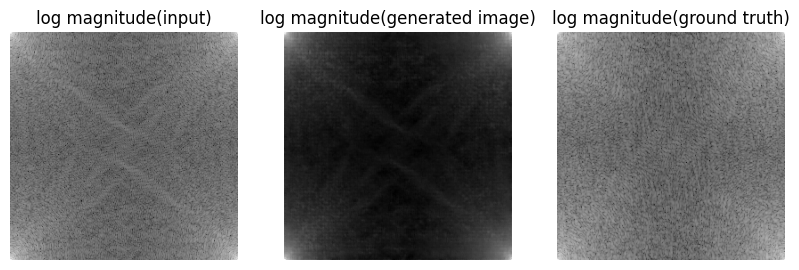

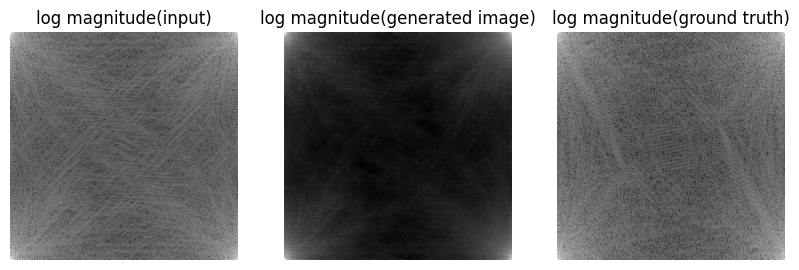

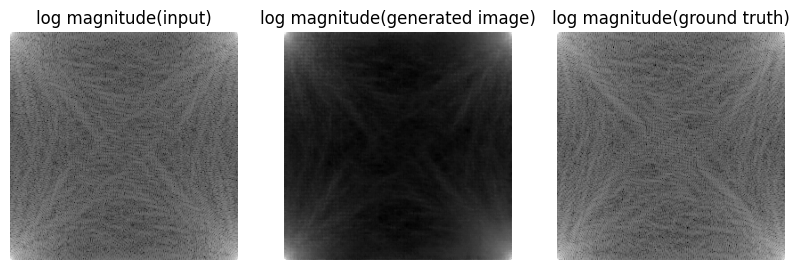

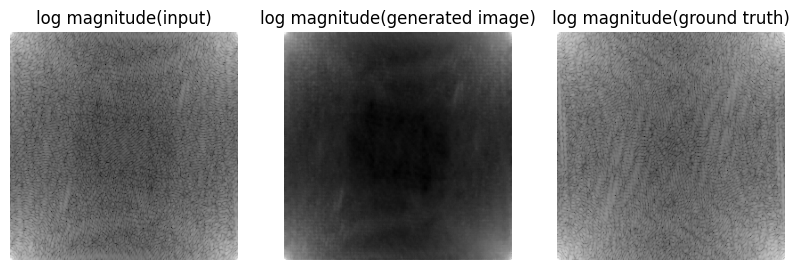

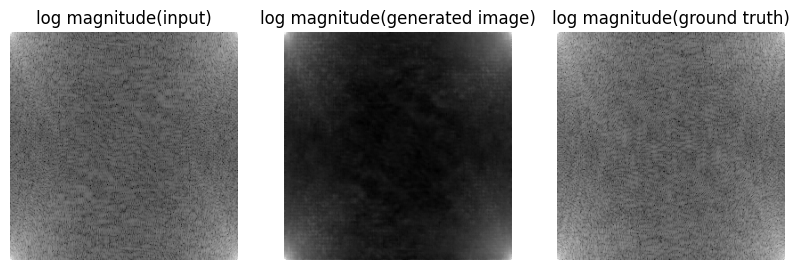

/var/tmp/pbs.37112.pbshpc/ipykernel_241470/1970618820.py:8: RuntimeWarning: invalid value encountered in log1p
  magnitude_log = np.log1p(magnitude)


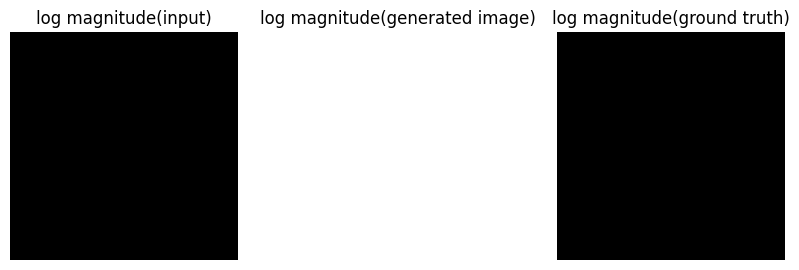

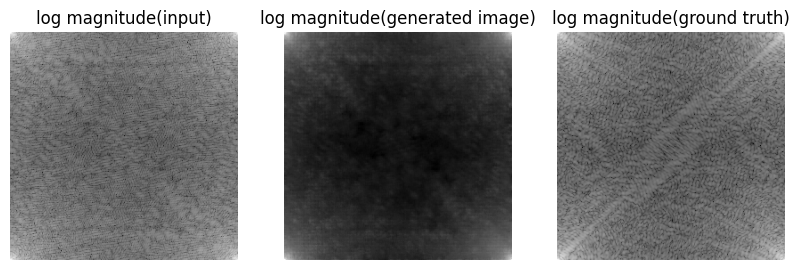

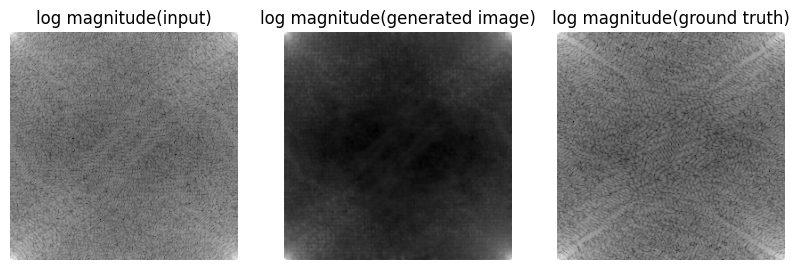

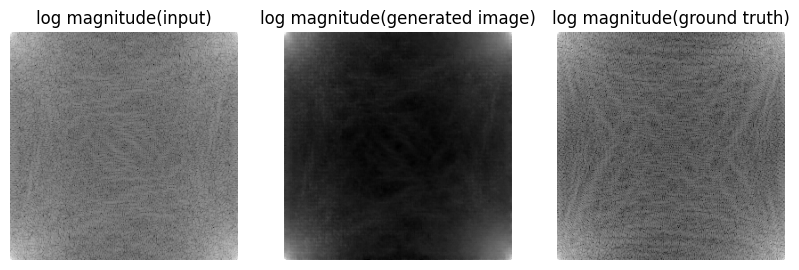

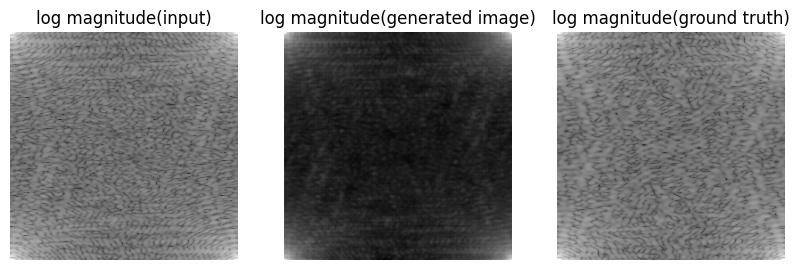

In [91]:

# visualising the log magnitude of fourier transform of test dataset
min_value=math.log(-3.1416+4.5)
max_value=math.log(4239579+4.5)

c=0
for data in (test_loader):
    t_batch=data
    t_x, t_y = split(t_batch)
    
    with torch.no_grad():
        generator.eval()
        fk_batch=generator(t_x.to(device))
    t_y=t_y.numpy()
    fk_batch=fk_batch.cpu().detach().numpy()
    t_x=t_x.cpu().detach().numpy()
    
    t_x=t_x*(max_value-min_value)+min_value
    t_y=t_y*(max_value-min_value)+min_value
    fk_batch=fk_batch*(max_value-min_value)+min_value
    
    t_x=np.exp(t_x.squeeze())-4.5
    t_y=np.exp(t_y.squeeze())-4.5
    fk_batch=np.exp(fk_batch.squeeze())-4.5

   
    mag_t_x=fft_visual(t_x)
    mag_t_y=fft_visual(t_y)
    mag_fk_batch=fft_visual(fk_batch)
    
    
    plt.figure(figsize=(10, 4))

    # Plotting the first array
    plt.subplot(1, 3, 1)
    plt.imshow(mag_t_x,cmap='gray')
    plt.title('log magnitude(input)')
    plt.axis('off')
    
    # Plotting the second array
    plt.subplot(1, 3, 2)
    plt.imshow(mag_fk_batch,cmap='gray')
    plt.title('log magnitude(generated image)')
    plt.axis('off')
    
    # Plotting the third array
    plt.subplot(1, 3, 3)
    plt.imshow(mag_t_y,cmap='gray')
    plt.title('log magnitude(ground truth)')
    plt.axis('off')

    c+=1

    plt.show()
    
    if c==10:
        break

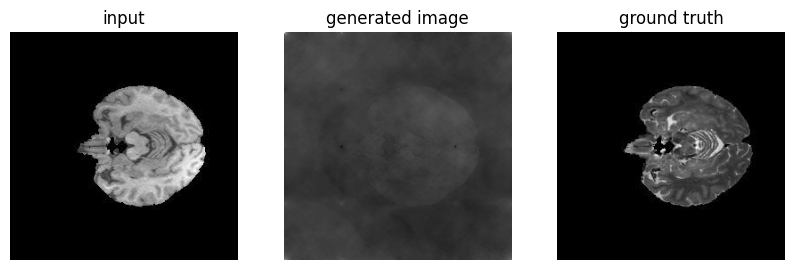

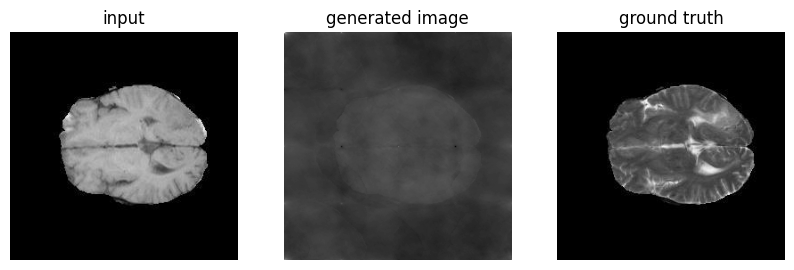

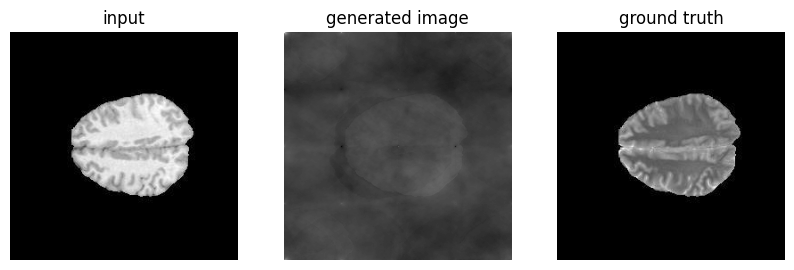

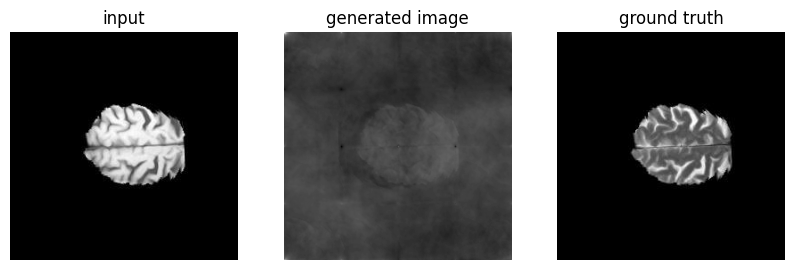

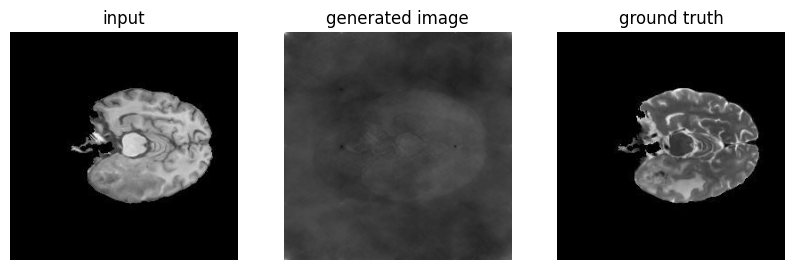

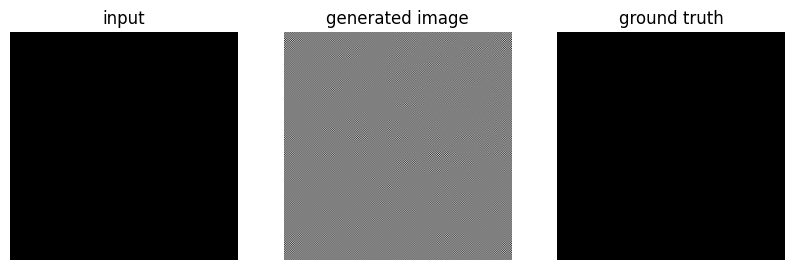

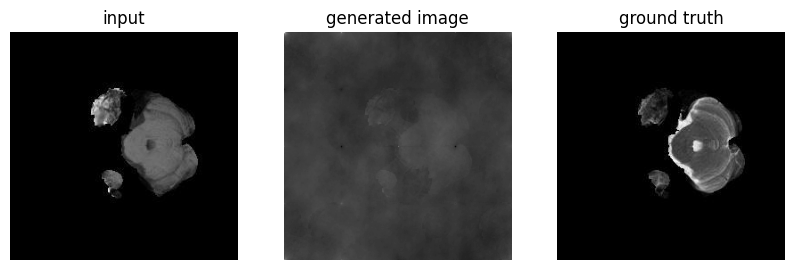

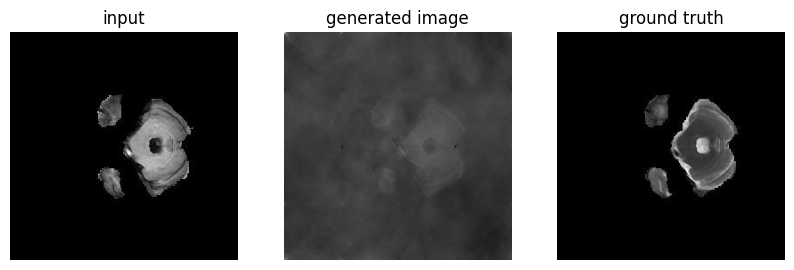

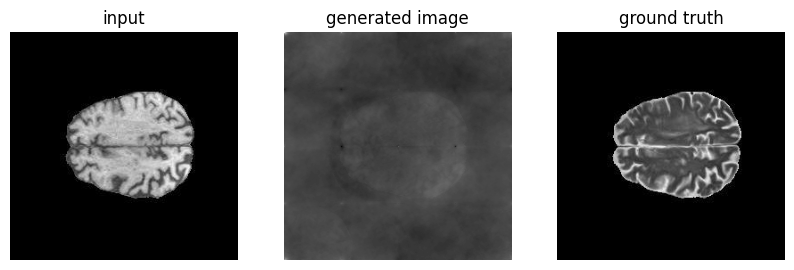

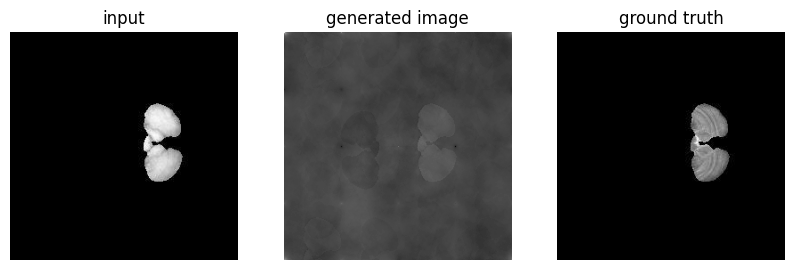

In [89]:

# visualising the spatial results  of test dataset
min_value=math.log(-3.1416+4.5)
max_value=math.log(4239579+4.5)

c=0
for data in (test_loader):
    t_batch=data
    t_x, t_y = split(t_batch)
    
    with torch.no_grad():
        generator.eval()
        fk_batch=generator(t_x.to(device))
    t_y=t_y.numpy()
    fk_batch=fk_batch.cpu().detach().numpy()
    t_x=t_x.cpu().detach().numpy()
    
    t_x=t_x*(max_value-min_value)+min_value
    t_y=t_y*(max_value-min_value)+min_value
    fk_batch=fk_batch*(max_value-min_value)+min_value
    
    t_x=np.exp(t_x.squeeze())-4.5
    t_y=np.exp(t_y.squeeze())-4.5
    fk_batch=np.exp(fk_batch.squeeze())-4.5

    
    
    t_x=inverseFCT(t_x)
    t_y=inverseFCT(t_y)
    fk_batch=inverseFCT(fk_batch)

    normalized_t_x=Normalize()(t_x)
    normalized_fk_batch=Normalize()(fk_batch)
    normalized_t_y=Normalize()(t_y)

    plt.figure(figsize=(10, 4))

    # Plotting the first array
    plt.subplot(1, 3, 1)
    plt.imshow(normalized_t_x,cmap='gray')
    plt.title('input')
    plt.axis('off')
    
    # Plotting the second array
    plt.subplot(1, 3, 2)
    plt.imshow(normalized_fk_batch,cmap='gray')
    plt.title('generated image')
    plt.axis('off')
    # Plotting the third array
    plt.subplot(1, 3, 3)
    plt.imshow(normalized_t_y,cmap='gray')
    plt.title('ground truth')
    plt.axis('off')

    c+=1

    plt.show()

    
    if c==10:
        break